In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import wavfile
import os
import numpy as np
import pandas as pd
from scipy.fft import fft # fast fourier transform
""" The objective of this copy is to slice up the audio sample,
    do separate FFTs and find the FF of each chunk.
    This differs from the spectrogram in the sense that everything is
    given in terms of multiples of the FF."""

' The objective of this copy is to slice up the audio sample,\n    do separate FFTs and find the FF of each chunk.\n    This differs from the spectrogram in the sense that everything is\n    given in terms of multiples of the FF.'

IMPORTING FILE

Audio data shape is
(141120, 2)


Text(0.5, 1.0, 'Audio signal in time')

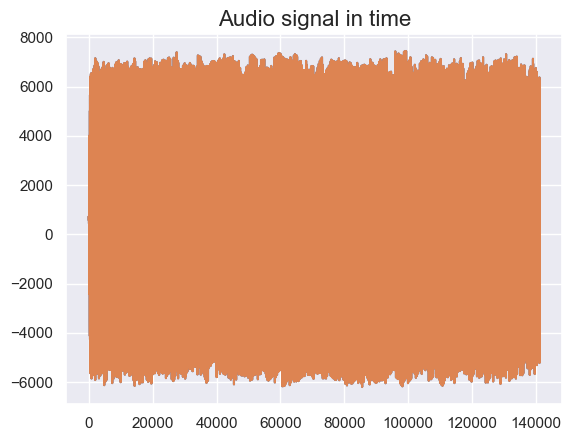

In [2]:
""" Note: Each sample in my set releases the note halfway.
False -> we train with the release behavior (not a good idea).
True -> we don't, and we only use the first half of each sample.
"""
dont_use_release = True

SampleName = "01 - [Prologue]_1.wav" # Audio File
os.chdir('./data/wav/')
SampleRate, Audiodata = wavfile.read(SampleName)

if dont_use_release:
    Audiodata = Audiodata[0:len(Audiodata)//2,:]

print('Audio data shape is') #Old shape was (35280,2)
print(np.shape(Audiodata))

# Plot the audio signal in time
plt.plot(Audiodata)
plt.title('Audio signal in time',size=16)

FAST FOURIER TRANSFORM \& SPECTRUM

FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
FFT of audio data shape is
(4096,)
           0           1           2           3          4          5   \
0  356.910593  418.043989  206.345312  311.518403  75.713112  89.445907   
1  153.449029  193.034174   84.912155  156.605589  29.632595  41.061662   
2   12.784299    5.491926   10.753030   19.954719   8.965806   8.446207   
3   10.800389    3.754600    6.621077   13.281101   5.530576   7.578678   
4   16.395623   16.504262    4.356623   15.518855   1.889006   9.

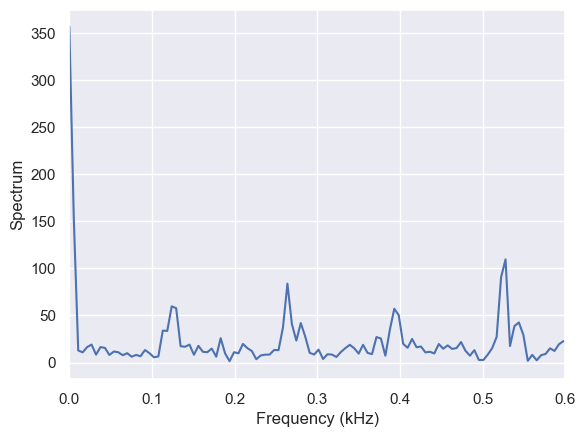

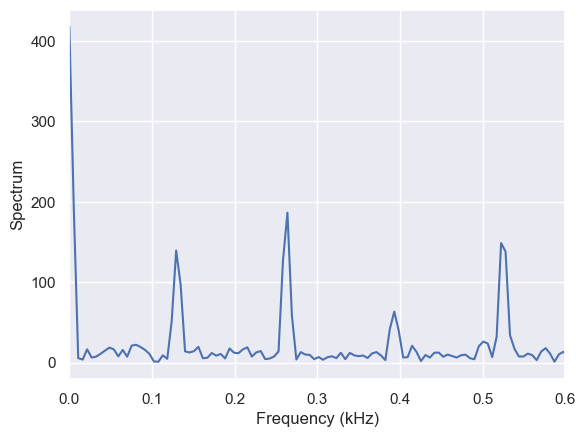

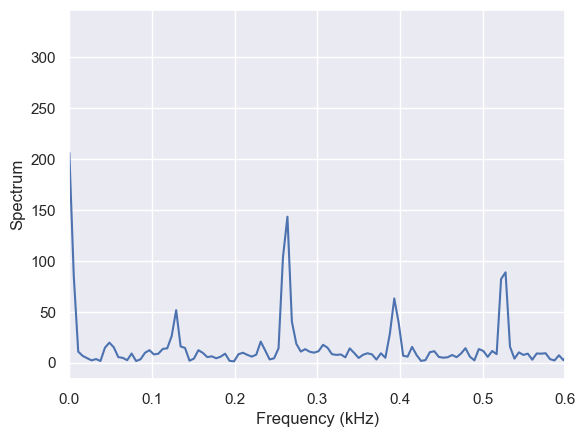

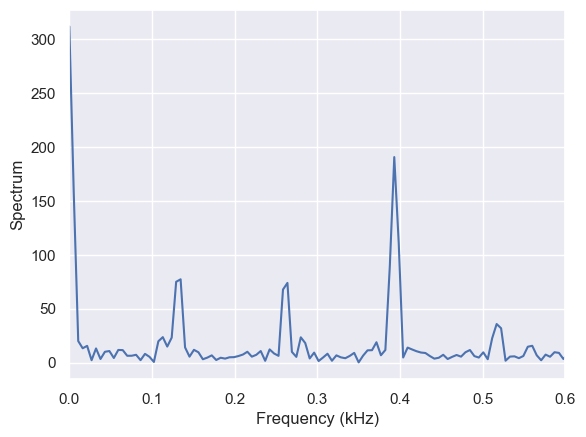

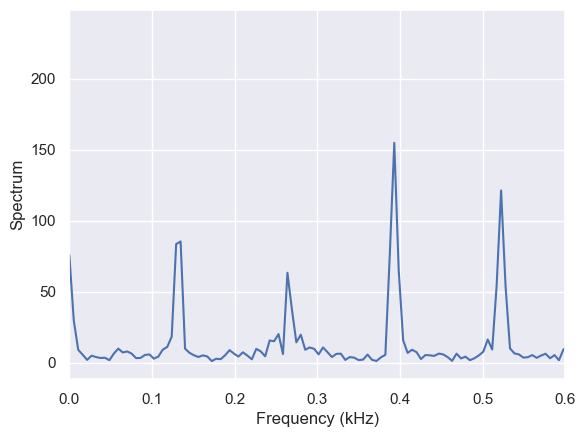

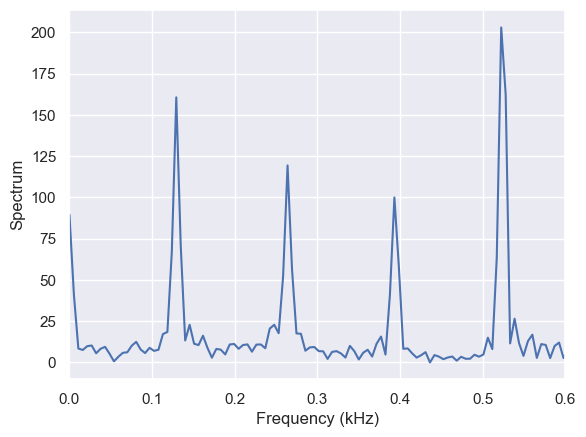

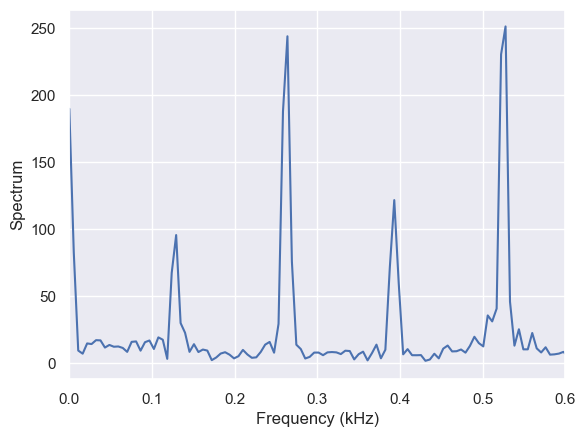

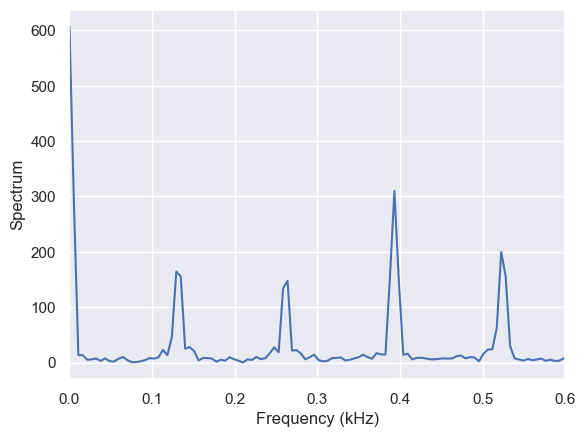

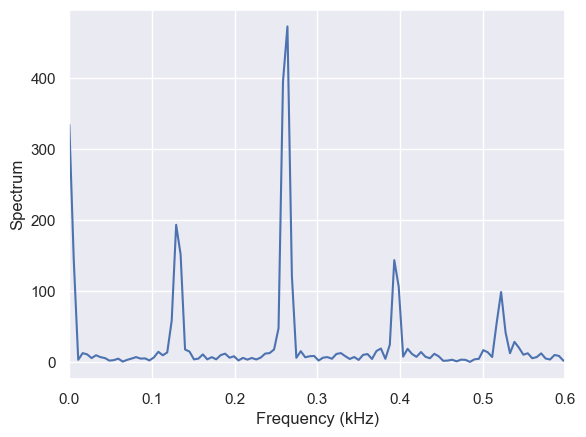

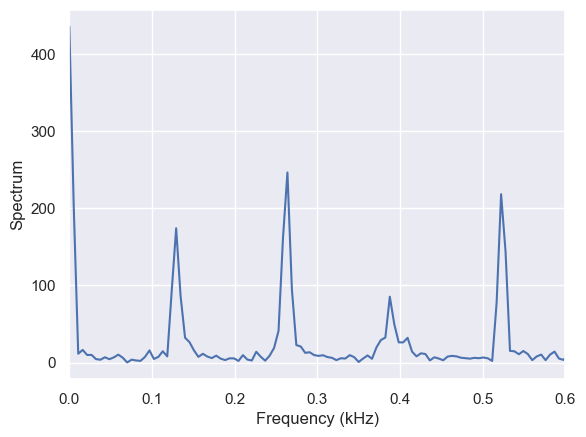

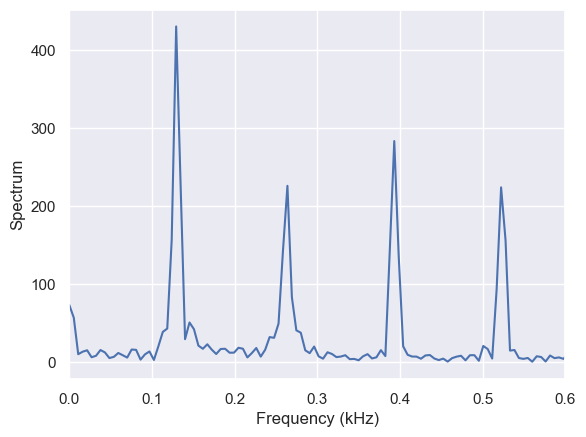

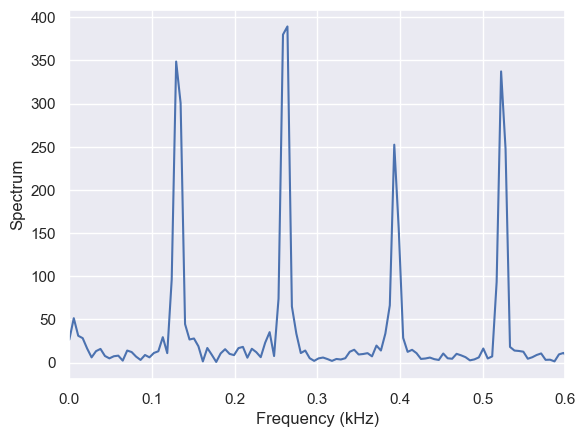

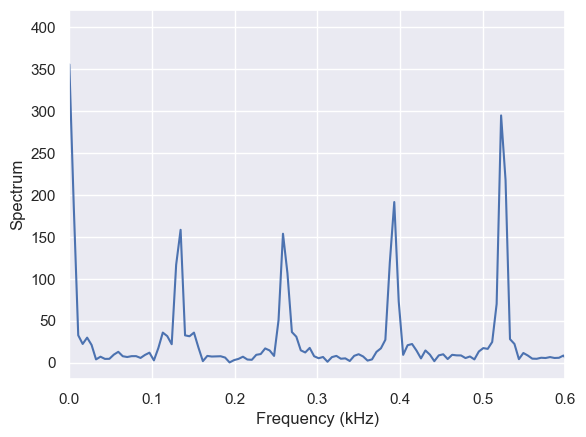

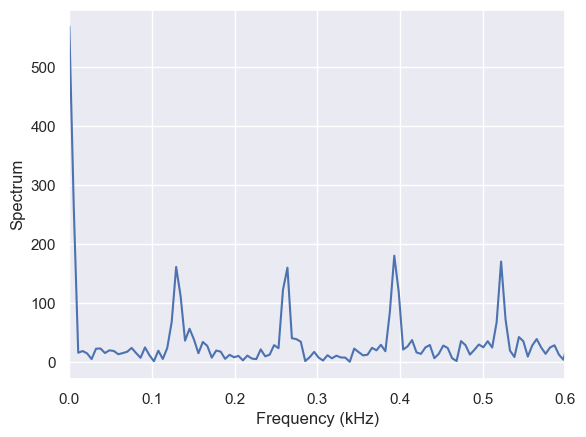

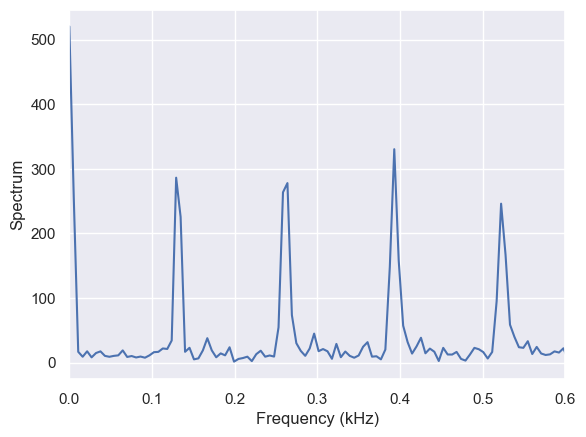

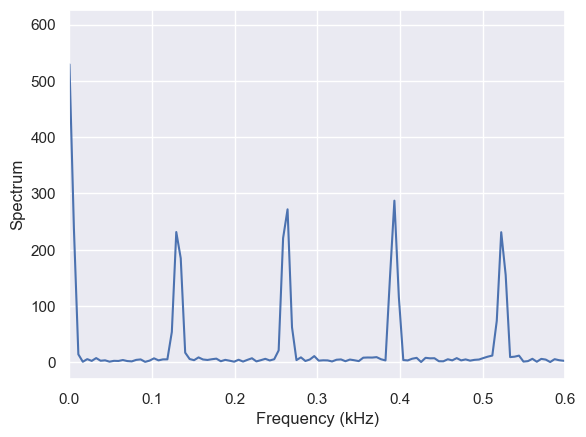

In [3]:
num_pieces = 16 # Each sample is 3.2 seconds without release tail, 6.4 seconds with it.
m = len(Audiodata)
piece_size = int(m / num_pieces)

FFTSize = 8192 # have to use a multiple of 2 for optimal speed. Old was 8192
Freq_series = pd.DataFrame()

for i in np.arange(0, num_pieces):
    AudioFreq = fft(Audiodata[i*piece_size:(i+1)*piece_size,1]*np.hanning(np.shape(Audiodata)[0]/num_pieces),n=FFTSize,axis=0) #with a Hanning window
    AudioFreq = AudioFreq[0:int(np.ceil((np.shape(AudioFreq)[0])/2.0))] #Left half of the spectrum
    MagFreq = np.abs(AudioFreq) # Magnitude
    MagFreq = MagFreq / float(piece_size)
    print('FFT of audio data shape is') # Old shape was (4096,)
    print(np.shape(MagFreq))
    plt.figure()
    freqAxis = np.arange(0,int(np.ceil((piece_size+1)/2.0)), int(np.ceil((piece_size+1)/2.0))*2/FFTSize) * (SampleRate / piece_size);
    plt.plot(freqAxis/1000.0, MagFreq) #Spectrum
    plt.xlabel('Frequency (kHz)'); plt.ylabel('Spectrum');
    plt.xlim([0, 0.6])
    Freq_series[i] = MagFreq

print(Freq_series.head())

FINDING THE FUNDAMENTAL FREQUENCY, ASSESSING ACCURACY OF THE FF, \& MEASURING SPIKES

Fundamental frequency's location is at index...  389
Fundamental frequency is... 2094.578857421875 Hz.
(4096,)
(8192,)


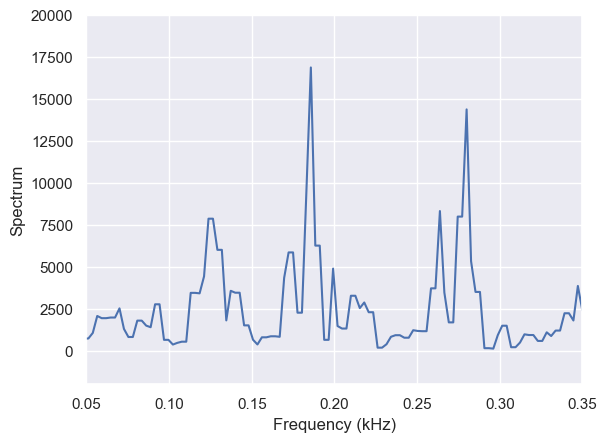

In [26]:
# HPS (Harmonic Product Spectrum) Algorithm to determine fundamental frequency
"""Basic rundown of the algorithm:
    This is a back-of-the-envelope approach to finding the FF.
    Let f_1(x) = original transform, f_2(x) = f_1(2x), and f_3(x) = f_1(3x). Let HPS(x) = f_1 * f_2 * f_3.
    The maximum is at a peak corresponding to the location of the fundamental frequency, since most spikes
    will appear at multiples of the FF.
    In practice, have to stretch the array so no data loss.
    f_1 is represented by MagFreq3, f_2 by MF2, and f_3 by MF3.
    Factors of 2, 3, and 6 because want integer ratios (6/1 = 6, 6/2 = 3, and 6/3 = 2).
    """

stretch_type = 'repeat' # Options: 'interp' or 'repeat'.
k = len(MagFreq)

for i in np.arange(0, 1): #replace with num_pieces when done debugging
    Frequencies = np.array(Freq_series[i])
    if (stretch_type == 'interp'):
        FreqMeans = (Frequencies + np.roll(Frequencies, -1)) / 2.0
        FreqMeans[-1] = Frequencies[-1]
        MagFreq1 = np.column_stack((Frequencies, FreqMeans1)).reshape(2*k,1)
        FreqDelta = np.roll(Frequencies, -1) - Frequencies
        FreqOneThird = Frequencies + FreqDelta / 3.0
        FreqTwoThirds = Frequencies + FreqDelta * 2.0 / 3.0
        MagFreq2 = np.column_stack((Frequencies, FreqOneThird,FreqTwoThirds)).reshape(3*k,1)
        FreqOneSixth = Frequencies + FreqDelta / 6.0
        FreqTwoSixths = Frequencies + FreqDelta * 2.0 / 6.0
        FreqThreeSixths = Frequencies + FreqDelta * 3.0 / 6.0
        FreqFourSixths = Frequencies + FreqDelta * 4.0 / 6.0
        FreqFiveSixths = Frequencies + FreqDelta * 5.0 / 6.0
        MagFreq3 = np.column_stack((Frequencies, FreqOneSixth,FreqTwoSixths,FreqThreeSixths,FreqFourSixths,FreqFiveSixths)).reshape(6*k,1)
    if (stretch_type == 'repeat'):
        MagFreq1 = np.repeat(Frequencies, 2)
        MagFreq2 = np.repeat(Frequencies, 3)
        MagFreq3 = np.repeat(Frequencies, 6)
    HPS = MagFreq1 * MagFreq2[0:2*k] * MagFreq3[0:2*k]
    freqAxisScaled = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))/FFTSize) * (SampleRate / m);
    plt.plot(freqAxisScaled/1000.0, HPS)
    plt.xlabel('Frequency (kHz)'); plt.ylabel('Spectrum');
    plt.xlim([0.05, 0.35])
    plt.ylim([-2000, 20000])
    FFLocHPS = np.argmax(HPS[freqAxisScaled >= 50]) + int(len(HPS[freqAxisScaled < 50])) # don't look below 50 Hz for it, due to noise.
    FFLocation = FFLocHPS // 3 # FFLocHPS uses an index that is scaled by 2. Have to reverse that.
    if (Frequencies[FFLocation + 1] > Frequencies[FFLocation]):
        FFLocation += 1
    print('Fundamental frequency\'s location is at index... ',FFLocation)
    print('Fundamental frequency is...',freqAxis[FFLocation],'Hz.')

print(np.shape(freqAxis))
print(np.shape(freqAxisScaled))


Old FF code. Will try the second approach I've written down.

In [ ]:
# HPS (Harmonic Product Spectrum) Algorithm to determine fundamental frequency

k = len(MagFreq)
HPSSizeFloat = k/3.0
HPSSize = int(np.ceil(k)/3.0 + 1)

for i in np.arange(0, 1): #replace with num_pieces when done debugging
    MagFreq2 = np.array(Freq_series[i]).reshape(int(np.ceil(k)/2.0),2).mean(1)[0:HPSSize]
    MagFreq3 = np.concatenate([np.array(Freq_series[i]),np.zeros(3 - int(k) % 3)]).reshape(int(np.ceil(k)/3.0 + 1),3).mean(1)[0:HPSSize]
    print(np.shape(MagFreq2))
    print(np.shape(MagFreq3))
    HPS = np.array(Freq_series[i])[0:HPSSize]*MagFreq2*MagFreq3
    freqAxisDownscaled = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))*6/FFTSize) * (SampleRate / m);
    FFLocHPS = np.argmax(HPS[freqAxisDownscaled >= 50]) + int(len(HPS[freqAxisDownscaled < 50])) # don't look below 50 Hz for it, due to noise.
    FFLocation = (FFLocHPS-1)*3 # FFLocHPS uses an index that is scaled down by 1/3. Have to reverse that.
    print('Fundamental frequency\'s location is at index... ',FFLocation)
    print('Fundamental frequency is...',freqAxis[FFLocation],'Hz.')
    # Have to ensure the fundamental frequency is accurate. Take loudest spike, get its approximate ratio, round to nearest int.
    MaxLoc = np.argmax(MagFreq[freqAxis >= 50]) + int(len(MagFreq[freqAxis < 50])) # don't look below 50 Hz for it, due to noise.
    MaxRatio = np.max([np.round(freqAxis[MaxLoc]/freqAxis[FFLocation]), 1])
    print('The loudest ratio is ',MaxRatio)
    FFreq = freqAxis[MaxLoc]/MaxRatio
    print('Corrected fundamental frequency is ',FFreq,' Hz.')
    MagFreqLog = 10*np.log10(MagFreq)
    FFreqLoc = np.argmin(np.abs(freqAxis - FFreq))
    print('Closest match found at index ',FFreqLoc)
    # If the frequency immediately on either side of each "spike" is louder, make that the new spike.
    FFreqLoc = FFreqLoc - ((MagFreqLog <= np.roll(MagFreqLog,1)) & (np.roll(MagFreqLog,-1) <= np.roll(MagFreqLog,1))) #if the left entry is >= the entry and the right entry, then make the left entry the new spike location
    FFreqLoc = FFreqLoc + ((MagFreqLog <= np.roll(MagFreqLog,-1)) & (np.roll(MagFreqLog,1) <= np.roll(MagFreqLog,-1)))  #if the right entry is >= the entry and the left entry, then make the right entry the new spike location
    numberSpikes = 20
    Multiples = [FFreq*i for i in np.arange(0,numberSpikes)]
    Multiples[0] = FFreq/2 # It turns out, telling the YM2612 to use the "0th" multiple means 1/2 the FF.
    print(Multiples)
    MultiplesLoc = [np.argmin(np.abs(freqAxis - i)) for i in Multiples]
    print(MultiplesLoc)
    # Next, make an integer ratio-indexed list of the amplitudes!
    MultiplesMag = MagFreq[MultiplesLoc]
    print(MultiplesMag)
    MultiplesdB = MagFreqLog[MultiplesLoc]
    print(MultiplesdB)

In [ ]:
print(MagFreq2)
print(MagFreq3)
